Conclusion: 
- it is not better with just inflow data

In [1]:
from sklearn.model_selection import train_test_split
import pandas as pd
import os
import sys
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler
# Get the directory of the current script
try:
    # This will work if the script is being run as a file
    current_dir = os.path.dirname(os.path.abspath(__file__))
except NameError:
    # Use the current working directory if __file__ is not defined
    current_dir = os.getcwd()
# Move up one directory level from EDA to the parent directory
parent_dir = os.path.dirname(current_dir)
# Construct the path to the xdrive folder
xdrive_path = os.path.join(parent_dir, 'xdrive')
# Add the xdrive path to sys.path
sys.path.append(xdrive_path)

featureeng_path = os.path.join(parent_dir, 'Feature Engineering')
# Add the xdrive path to sys.path
sys.path.append(featureeng_path)

# Construct the path to the xdrive folder
xdrive_path = os.path.join(parent_dir, 'Pipeline')
# Add the xdrive path to sys.path
sys.path.append(xdrive_path)
from build_a_pipeline import build_pipeline
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Flatten, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Flatten, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import TimeDistributed, Dense
from build_a_pipeline import build_pipeline_P0_foward_price


In [4]:

model_performance = []
x_train, x_val, X_test, y_train, y_val, y_test = build_pipeline_P0_foward_price(target_column = 'P0')
x_train = x_train[['Hydro_Inflow_N(MWavg)', 'Hydro_Inflow_NE(MWavg)',
       'Hydro_Inflow_S(MWavg)', 'Hydro_Inflow_SE/CW(MWavg)',
       'Daily_Sum_Hydro_Inflow(MWavg)']]
x_val =  x_val[['Hydro_Inflow_N(MWavg)', 'Hydro_Inflow_NE(MWavg)',
       'Hydro_Inflow_S(MWavg)', 'Hydro_Inflow_SE/CW(MWavg)',
       'Daily_Sum_Hydro_Inflow(MWavg)']]
X_test = X_test[['Hydro_Inflow_N(MWavg)', 'Hydro_Inflow_NE(MWavg)',
       'Hydro_Inflow_S(MWavg)', 'Hydro_Inflow_SE/CW(MWavg)',
       'Daily_Sum_Hydro_Inflow(MWavg)']]
datetime_index = x_val.index
# Convert x_train and x_val to NumPy arrays
x_val_original = x_val
X_test_original = X_test
x_train = x_train.to_numpy()
x_val = x_val.to_numpy()
# Reshape x_train and x_val to have the required 3D shape
x_train = x_train.reshape(x_train.shape[0], 1, x_train.shape[1])  # [samples, time_steps=1, features]
x_val = x_val.reshape(x_val.shape[0], 1, x_val.shape[1])    



In [5]:

# Build the LSTM model
multivariate_lstm = Sequential([
    LSTM(195, input_shape=(x_train.shape[1], x_train.shape[2]), return_sequences=True),
    TimeDistributed(Dense(95, activation='selu')), 
    Flatten(),
    Dense(1)  # Output layer
])

# ModelCheckpoint to save the best model based on validation loss
model_checkpoint = ModelCheckpoint('multivariate_lstm.keras', monitor='val_loss', save_best_only=True)

# EarlyStopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Optimizer with adjusted learning rate
optimizer = Adam(learning_rate=6e-3, amsgrad=True)

# Loss function and metric
loss = tf.keras.losses.MeanSquaredError()
metric = [tf.keras.metrics.RootMeanSquaredError()]

# Compile the model
multivariate_lstm.compile(loss=loss, optimizer=optimizer, metrics=metric)

# Train the model (make sure you pass both x_val and y_val)
history = multivariate_lstm.fit(x_train, y_train, epochs=120,
                                validation_data=(x_val, y_val),
                                callbacks=[early_stopping, model_checkpoint])

# Optionally, print the final RMSE
train_rmse = history.history['root_mean_squared_error'][-1]
val_rmse = history.history['val_root_mean_squared_error'][-1]
print(f"Final train RMSE: {train_rmse}")
print(f"Final validation RMSE: {val_rmse}")
model_performance.append({
    'Model': '1st Model',
    'LayerExtra': 'TimeDistributed, LSTM',
    'Train RMSE': train_rmse,
    'Validation RMSE': val_rmse
})

Epoch 1/120


C:\Users\veron\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 33991.9727 - root_mean_squared_error: 183.8020 - val_loss: 3540.5366 - val_root_mean_squared_error: 59.5024
Epoch 2/120
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 23217.8750 - root_mean_squared_error: 152.1899 - val_loss: 4424.2710 - val_root_mean_squared_error: 66.5152
Epoch 3/120
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 16936.9375 - root_mean_squared_error: 130.0892 - val_loss: 1461.9550 - val_root_mean_squared_error: 38.2355
Epoch 4/120
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 13724.8438 - root_mean_squared_error: 117.0927 - val_loss: 1149.6299 - val_root_mean_squared_error: 33.9062
Epoch 5/120
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 13509.1592 - root_mean_squared_error: 115.7801 - val_loss: 1848.4426 - val_root_mean_squared_error: 42.9935
Epoch 6/120
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 13245.4795 - root_mean_squared_error: 115.0449 - val_loss: 769.3149 - val_root_mean_squared_error: 27.7365
Epoch 7/12

Improved version

## Trying the pipeline with no feature selection dropping

In [7]:
x_train, x_val, X_test, y_train, y_val, y_test = build_pipeline_P0_foward_price(target_column = 'P0', drop_features = False)
x_train = x_train[['Hydro_Inflow_N(MWavg)', 'Hydro_Inflow_NE(MWavg)',
       'Hydro_Inflow_S(MWavg)', 'Hydro_Inflow_SE/CW(MWavg)',
       'Daily_Sum_Hydro_Inflow(MWavg)']]
x_val =  x_val[['Hydro_Inflow_N(MWavg)', 'Hydro_Inflow_NE(MWavg)',
       'Hydro_Inflow_S(MWavg)', 'Hydro_Inflow_SE/CW(MWavg)',
       'Daily_Sum_Hydro_Inflow(MWavg)']]
X_test = X_test[['Hydro_Inflow_N(MWavg)', 'Hydro_Inflow_NE(MWavg)',
       'Hydro_Inflow_S(MWavg)', 'Hydro_Inflow_SE/CW(MWavg)',
       'Daily_Sum_Hydro_Inflow(MWavg)']]

# Convert x_train and x_val to NumPy arrays
x_train = x_train.to_numpy()
x_val = x_val.to_numpy()
# Reshape x_train and x_val to have the required 3D shape
x_train = x_train.reshape(x_train.shape[0], 1, x_train.shape[1])  # [samples, time_steps=1, features]
x_val = x_val.reshape(x_val.shape[0], 1, x_val.shape[1])    

In [8]:
import os
import random
import numpy as np
import tensorflow as tf

seed_value = 42
os.environ['PYTHONHASHSEED'] = str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

In [9]:
from tensorflow.keras.initializers import GlorotUniform
# Build the LSTM model
multivariate_lstm = Sequential([
    LSTM(195, input_shape=(x_train.shape[1], x_train.shape[2]), kernel_initializer=GlorotUniform(seed=42), return_sequences=True),
    TimeDistributed(Dense(95, activation='selu', kernel_initializer=GlorotUniform(seed=42))), 
    Flatten(),
    Dense(1)  # Output layer
])

# ModelCheckpoint to save the best model based on validation loss
model_checkpoint = ModelCheckpoint('multivariate_lstm.keras', monitor='val_loss', save_best_only=True)

# EarlyStopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Optimizer with adjusted learning rate
optimizer = Adam(learning_rate=6e-3, amsgrad=True, clipnorm=1.0)
#optimizer = Adam(learning_rate=0.001, clipnorm=1.0)

# Loss function and metric
loss = tf.keras.losses.MeanSquaredError()
metric = [tf.keras.metrics.RootMeanSquaredError()]

# Compile the model
multivariate_lstm.compile(loss=loss, optimizer=optimizer, metrics=metric)

# Train the model (make sure you pass both x_val and y_val)
history = multivariate_lstm.fit(x_train, y_train, epochs=120,
                                validation_data=(x_val, y_val),
                                callbacks=[early_stopping, model_checkpoint])

# Optionally, print the final RMSE
train_rmse = history.history['root_mean_squared_error'][-1]
val_rmse = history.history['val_root_mean_squared_error'][-1]
print(f"Final train RMSE: {train_rmse}")
print(f"Final validation RMSE: {val_rmse}")
model_performance.append({
    'Model': '1st Model',
    'LayerExtra': 'TimeDistributed, LSTM',
    'Train RMSE': train_rmse,
    'Validation RMSE': val_rmse
})

Epoch 1/120


C:\Users\veron\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 31049.6406 - root_mean_squared_error: 175.5125 - val_loss: 3367.3220 - val_root_mean_squared_error: 58.0286
Epoch 2/120
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 23217.0312 - root_mean_squared_error: 151.9933 - val_loss: 2814.7271 - val_root_mean_squared_error: 53.0540
Epoch 3/120
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 15351.5674 - root_mean_squared_error: 123.7247 - val_loss: 3005.6912 - val_root_mean_squared_error: 54.8242
Epoch 4/120
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 14223.1748 - root_mean_squared_error: 119.1607 - val_loss: 1535.2957 - val_root_mean_squared_error: 39.1828
Epoch 5/120
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 13018.4883 - root_mean_squared_error: 113.9070 - val_loss: 1267.8804 - val_root_mean_squared_error: 35.6073
Epoch 6/120
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 12467.8359 - root_mean_squared_error: 111.4754 - val_loss: 1335.1340 - val_root_mean_squared_error: 36.5395
Epoch 7/1

In [10]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Flatten, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import TimeDistributed, Dense

# Build the LSTM multivariate_lstm
multivariate_lstm = Sequential([
    LSTM(200, input_shape=(x_train.shape[1], x_train.shape[2]), return_sequences=True),
    TimeDistributed(Dense(100, activation='relu')), 
    Flatten(),
    Dense(1)  # Output layer
])

# ModelCheckpoint to save the best multivariate_lstm based on validation loss
model_checkpoint = ModelCheckpoint('multivariate_lstm.keras', monitor='val_loss', save_best_only=True)

# EarlyStopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Optimizer with adjusted learning rate
optimizer = Adam(learning_rate=6e-3, amsgrad=True)

# Loss function and metric
loss = tf.keras.losses.MeanSquaredError()
metric = [tf.keras.metrics.RootMeanSquaredError()]

# Compile the multivariate_lstm
multivariate_lstm.compile(loss=loss, optimizer=optimizer, metrics=metric)

# Train the multivariate_lstm (make sure you pass both x_val and y_val)
history = multivariate_lstm.fit(x_train, y_train, epochs=120,
                                validation_data=(x_val, y_val),
                                callbacks=[early_stopping, model_checkpoint])

# Optionally, print the final RMSE
train_rmse = history.history['root_mean_squared_error'][-1]
val_rmse = history.history['val_root_mean_squared_error'][-1]
print(f"Final train RMSE: {train_rmse}")
print(f"Final validation RMSE: {val_rmse}")

model_performance.append({
    'multivariate_lstm': multivariate_lstm,
    'Train RMSE': train_rmse,
    'Validation RMSE': val_rmse
})

Epoch 1/120


C:\Users\veron\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 31567.1270 - root_mean_squared_error: 176.9099 - val_loss: 3982.9482 - val_root_mean_squared_error: 63.1106
Epoch 2/120
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 24684.2207 - root_mean_squared_error: 156.7018 - val_loss: 2103.7319 - val_root_mean_squared_error: 45.8665
Epoch 3/120
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 14080.4062 - root_mean_squared_error: 118.4146 - val_loss: 2962.9070 - val_root_mean_squared_error: 54.4326
Epoch 4/120
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 14062.1631 - root_mean_squared_error: 118.4771 - val_loss: 1451.9390 - val_root_mean_squared_error: 38.1043
Epoch 5/120
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 12408.1943 - root_mean_squared_error: 111.2092 - val_loss: 1334.2021 - val_root_mean_squared_error: 36.5267
Epoch 6/120
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 11847.2520 - root_mean_squared_error: 108.7306 - val_loss: 997.3482 - val_root_mean_squared_error: 31.5808
Epoch 7/12

In [11]:
from tensorflow.keras.models import load_model
best_model = load_model('multivariate_lstm.keras')
y_pred = best_model.predict(x_val)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


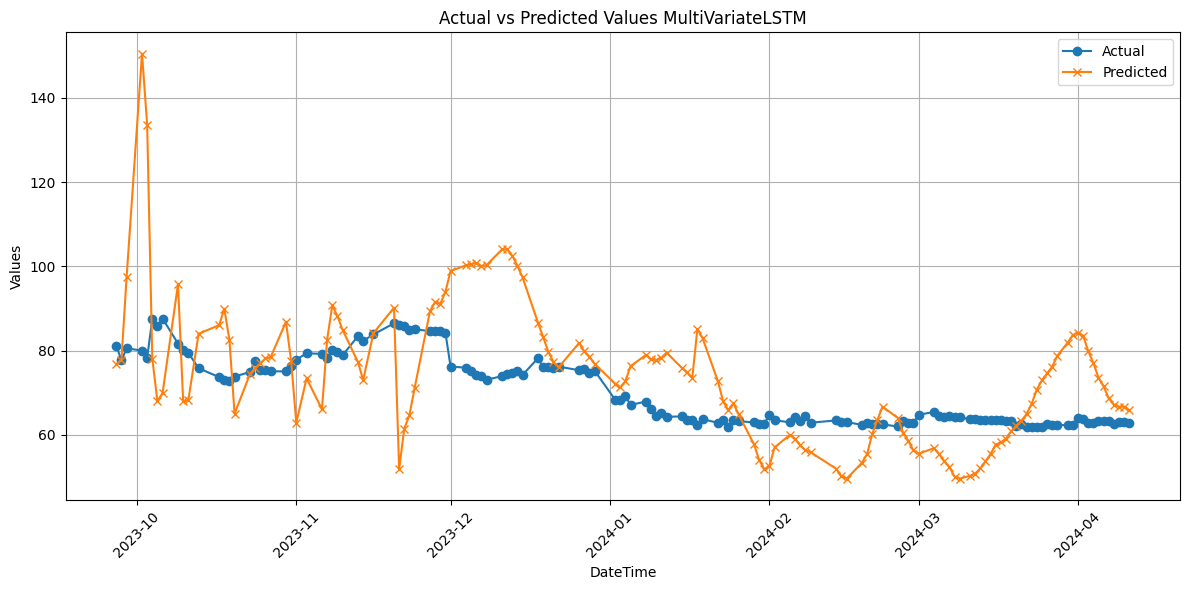

In [12]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

y_pred = y_pred.flatten()
predictions_df = pd.DataFrame(y_pred, index=datetime_index, columns=['Predicted'])
predictions_df = predictions_df.sort_index()
y_val = y_val.sort_index()

# Plotting y_actual vs y_pred
plt.figure(figsize=(12, 6))
plt.plot(y_val.index, y_val, label='Actual', marker='o')
plt.plot(y_val.index, predictions_df['Predicted'], label='Predicted', marker='x')
plt.title('Actual vs Predicted Values MultiVariateLSTM')
plt.xlabel('DateTime')
plt.ylabel('Values')

# Rotate the x-axis labels for better visibility
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [ ]:
import plotly.graph_objects as go

# Assuming `df` is the DataFrame with 42 columns and `x_val_original` contains 'Average_Settlement_Price_SE/CW(MWh)'
# Create the figure
fig = go.Figure()

# Plot the columns from df
for column in predictions_df.columns:
    fig.add_trace(go.Scatter(x=predictions_df.index, y=predictions_df[column], mode='lines', name=column))

fig.add_trace(go.Scatter(x=y_val.index, y=y_val, mode='lines', name='Actual'))
fig.add_trace(go.Scatter(x=x_val_original.index, y=x_val_original['Average_Settlement_Price_SE/CW(MWh)'], mode='lines', name='Average_Settlement_Price_SE/CW(MWh)'))

# Plot the 'Average_Settlement_Price_SE/CW(MWh)' from x_val_original with a secondary y-axis
fig.add_trace(go.Scatter(x=x_val_original.index, 
                         y=x_val_original['Hydro_Inflow_NE(MWavg)'], 
                         mode='lines', 
                         name='Hydro_Inflow_NE(MWavg)', 
                         yaxis='y2'))  # Use the second y-axis

# Update layout to add a secondary y-axis
fig.update_layout(
    title='Visualization of All Columns in the Dataset',
    xaxis_title="DateTime or Index",
    yaxis_title="Values (df)",
    yaxis2=dict(
        title="Average Settlement Price (x_val_original)",
        overlaying="y",  # Overlay the second y-axis on the primary y-axis
        side="right",  # Place the secondary y-axis on the right
        showgrid=False  # Optionally hide the grid for the secondary y-axis
    ),
    xaxis_tickangle=45,  # Rotate x-axis labels for better visibility
    template="plotly_dark",  # Optional: change the theme
    width=1200,  # Optional: adjust plot width
    height=600,  # Optional: adjust plot height
)

# Show the interactive plot
fig.show()


## FINAL TESTING
- training on val and train
- testing on test

In [29]:
x_train, x_val, x_test, y_train, y_val, y_test = build_pipeline_P0_foward_price(target_column='P0', drop_features=False)
x_train = x_train[['Hydro_Inflow_N(MWavg)', 'Hydro_Inflow_NE(MWavg)',
       'Hydro_Inflow_S(MWavg)', 'Hydro_Inflow_SE/CW(MWavg)',
       'Daily_Sum_Hydro_Inflow(MWavg)']]
x_val =  x_val[['Hydro_Inflow_N(MWavg)', 'Hydro_Inflow_NE(MWavg)',
       'Hydro_Inflow_S(MWavg)', 'Hydro_Inflow_SE/CW(MWavg)',
       'Daily_Sum_Hydro_Inflow(MWavg)']]
x_test = x_test[['Hydro_Inflow_N(MWavg)', 'Hydro_Inflow_NE(MWavg)',
       'Hydro_Inflow_S(MWavg)', 'Hydro_Inflow_SE/CW(MWavg)',
       'Daily_Sum_Hydro_Inflow(MWavg)']]
datetime_index = x_test.index
#save these values for later
X_test_last= x_test.sort_index()
X_test_last = X_test_last.tail(10)
datetime_index_final = X_test_last.index
X_test_last = X_test_last.to_numpy()  # Convert DataFrame to NumPy array
X_test_last = X_test_last.reshape(X_test_last.shape[0], 1, X_test_last.shape[1])
y_test_last = y_test.sort_index()
y_test_last = y_test_last.tail(10)

x_train = x_train.to_numpy()
x_val = x_val.to_numpy()
x_test = x_test.to_numpy()
y_train = y_train.to_numpy()
y_val = y_val.to_numpy()
y_test = y_test.to_numpy()

# merge train and validation
x_train_combined = np.vstack([x_train, x_val])  # Combine x_train and x_val
y_train_combined = np.concatenate([y_train, y_val])  # Combine y_train and y_val

#reshape
x_train = x_train_combined.reshape(x_train_combined.shape[0], 1, x_train_combined.shape[1])  # [samples, time_steps=1, features]
# Test data
x_test = x_test.reshape(x_test.shape[0], 1, x_test.shape[1]) 

In [30]:
from tensorflow.keras.initializers import GlorotUniform
# Build the LSTM model
multivariate_lstm = Sequential([
    LSTM(105, input_shape=(x_train.shape[1], x_train.shape[2]), kernel_initializer=GlorotUniform(seed=42), return_sequences=True),
    Dropout(0.4),
    TimeDistributed(Dense(75, activation='selu', kernel_initializer=GlorotUniform(seed=42))), 
    Dropout(0.2),
    Flatten(),
    Dense(1)  # Output layer
])

# ModelCheckpoint to save the best model based on validation loss
model_checkpoint = ModelCheckpoint('multivariate_lstm.keras', monitor='val_loss', save_best_only=True)

# EarlyStopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Optimizer with adjusted learning rate
optimizer = Adam(learning_rate=6e-3, amsgrad=True, clipnorm=1.0)
#optimizer = Adam(learning_rate=0.001, clipnorm=1.0)

# Loss function and metric
loss = tf.keras.losses.MeanSquaredError()
metric = [tf.keras.metrics.RootMeanSquaredError()]

# Compile the model
multivariate_lstm.compile(loss=loss, optimizer=optimizer, metrics=metric)

history = multivariate_lstm.fit(x_train, y_train_combined, epochs=120,
                                validation_data=(x_test, y_test),
                                callbacks=[early_stopping, model_checkpoint])

# Optionally, print the final RMSE
train_rmse = history.history['root_mean_squared_error'][-1]
val_rmse = history.history['val_root_mean_squared_error'][-1]
print(f"Final train RMSE: {train_rmse}")
print(f"Final test RMSE: {val_rmse}")
model_performance.append({
    'Model': '1st Model',
    'LayerExtra': 'TimeDistributed, LSTM',
    'Train RMSE': train_rmse,
    'Validation RMSE': val_rmse
})

Epoch 1/120


C:\Users\veron\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 26901.8887 - root_mean_squared_error: 163.9721 - val_loss: 23237.1836 - val_root_mean_squared_error: 152.4375
Epoch 2/120
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 21055.2227 - root_mean_squared_error: 145.0544 - val_loss: 10028.6670 - val_root_mean_squared_error: 100.1432
Epoch 3/120
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 13325.2959 - root_mean_squared_error: 115.4137 - val_loss: 9457.1514 - val_root_mean_squared_error: 97.2479
Epoch 4/120
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 12418.6562 - root_mean_squared_error: 111.4090 - val_loss: 8633.1572 - val_root_mean_squared_error: 92.9148
Epoch 5/120
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 11599.9922 - root_mean_squared_error: 107.6665 - val_loss: 8539.2314 - val_root_mean_squared_error: 92.4080
Epoch 6/120
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 11395.7764 - root_mean_squared_error: 106.7302 - val_loss: 8507.0596 - val_root_mean_squared_error: 92.2337
Epoch

In [31]:
from tensorflow.keras.models import load_model
best_model = load_model('multivariate_lstm.keras')
y_pred = best_model.predict(x_test)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


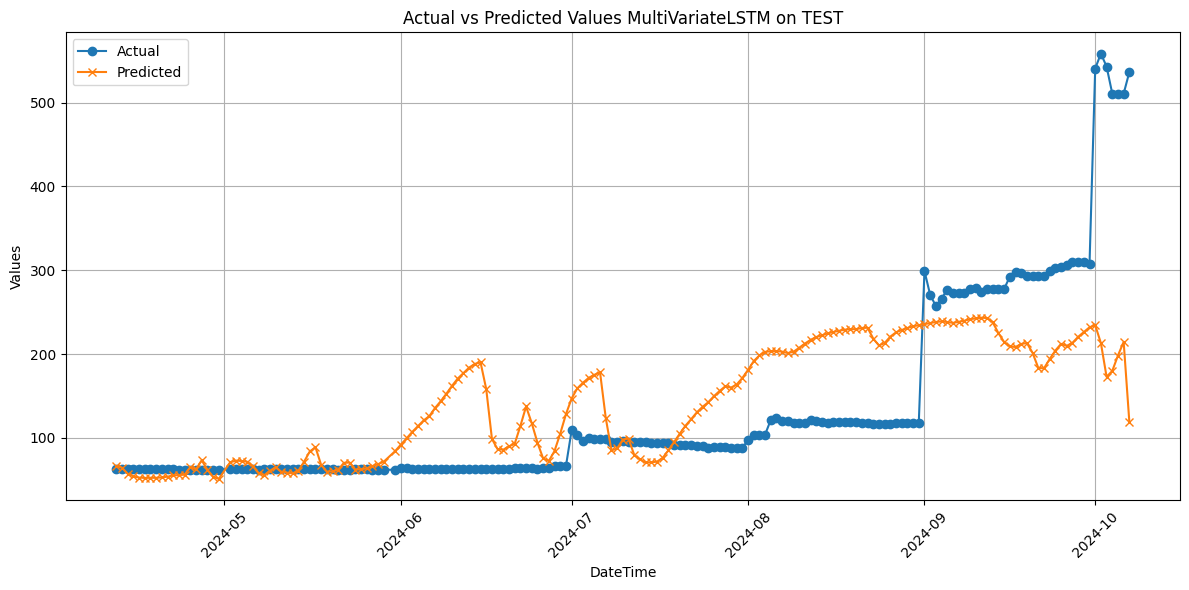

In [32]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

y_pred = y_pred.flatten()
predictions_df = pd.DataFrame(y_pred, index=datetime_index, columns=['Predicted'])
y_test_df = pd.DataFrame(y_test, index=datetime_index, columns=['Actual'])
predictions_df = predictions_df.sort_index()
y_test_df = y_test_df.sort_index()

# Plotting y_actual vs y_pred
plt.figure(figsize=(12, 6))
plt.plot(predictions_df.index, y_test_df['Actual'], label='Actual', marker='o')
plt.plot(y_test_df.index, predictions_df['Predicted'], label='Predicted', marker='x')
plt.title('Actual vs Predicted Values MultiVariateLSTM on TEST')
plt.xlabel('DateTime')
plt.ylabel('Values')

# Rotate the x-axis labels for better visibility
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

Last 10 values prediction

In [33]:
from tensorflow.keras.models import load_model
best_model = load_model('multivariate_lstm.keras')
y_pred = best_model.predict(X_test_last)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


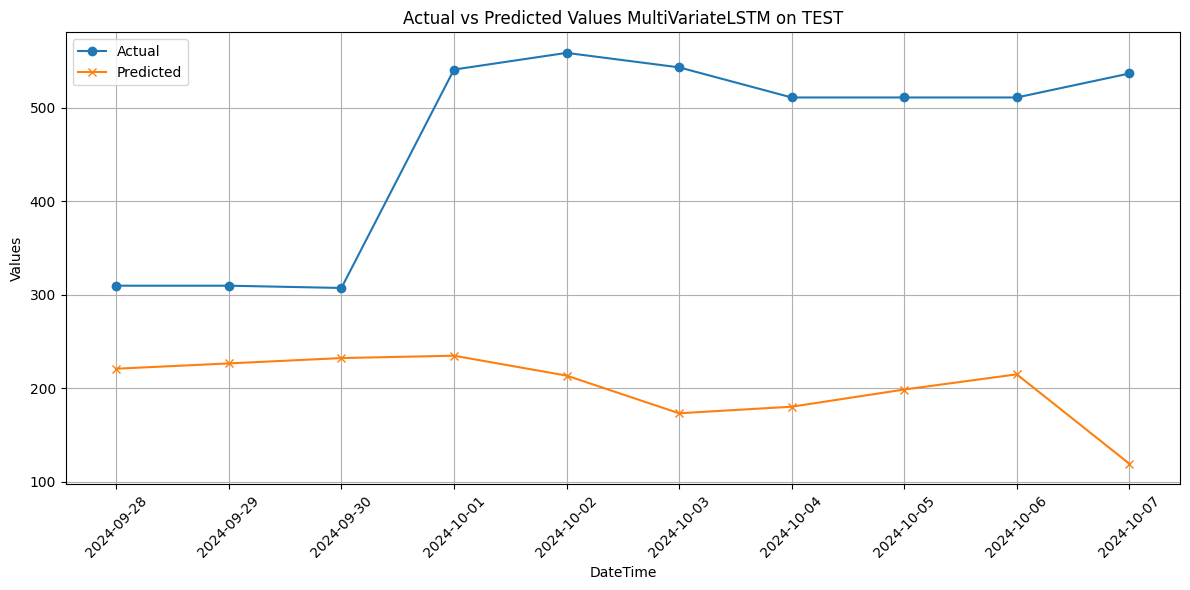

In [34]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
y_pred = y_pred.flatten()
predictions_df = pd.DataFrame(y_pred, index=datetime_index_final, columns=['Predicted'])
predictions_df = predictions_df.sort_index()

# Plotting y_actual vs y_pred
plt.figure(figsize=(12, 6))
plt.plot(y_test_last.index, y_test_last, label='Actual', marker='o')
plt.plot(predictions_df.index, predictions_df['Predicted'], label='Predicted', marker='x')
plt.title('Actual vs Predicted Values MultiVariateLSTM on TEST')
plt.xlabel('DateTime')
plt.ylabel('Values')

# Rotate the x-axis labels for better visibility
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()